# RNN (순환신경망)

* 기본적인 Neural Network는 메모리가 존재하지 않는다. 
    - input data가 개별적으로 처리되며, data가 Network를 타고 가는 동안 input이 유지되지 않는다.
    - 메모리가 없는 Network에서는 Sequence나 TimeSeries 데이터를 처리할 때, 네트워크 전체에 Sequence를 주입해야한다. 
       (**feedforward network**)
* 정보를 유지하면서 데이터를 점진적으로 처리해야 하는 경우, 처리된 정보를 State에 저장하여 주입되는 데이터를 점진적으로 처리 할 수 있다. 
    - Sequence 나 Time Series data를 점진적 처리가 가능해 진다. 
    - 데이터 상 Trend를 읽어내며 학습을 시킬 수 있다. 
    
![img](https://mblogthumb-phinf.pstatic.net/MjAxODA3MDJfMTMx/MDAxNTMwNTM3Mjk2ODU5.zzSxSkS3u7AsHBXCFp-ibsAlOWaJKgOCpEX6LPsMbXQg.yfb87i7Po7a42DciJ0pJsCIfnXSv9S31riJ0VhBx6HYg.PNG.magnking/image.png?type=w800)


In [1]:
import keras
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import konlpy
import re

from konlpy.tag import Okt
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [13]:
df1 = pd.read_excel('jobplanet.xlsx')
print(df1.shape)
df1.head()

(230, 6)


,Unnamed: 0,직무,ㅇㅇ,장점,단점,경영진
0,0,마케팅/시장조사,"\nBEST\n ""야근많은 전형적인 광고대행사. 자유로운 분...",\n복지 제도 좋은 편 - 수면실. 이노카페. 이노키친. TlX(현재 없어졌다고 함...,\n야근 쩔음. 야근수당 안해주려고함. 계약직/인턴은 복지 구림..야근 하는사람만 ...,"\n생각보다 계약직이 넘 많음. 우리 팀의 경우, 반 이상이 계약직이었는데 자꾸 사..."
1,1,디자인,"\nBEST\n ""업계 탑티어로 광고회사로 경험할 수 있는 ...","\n어디에도꿀리지않음, 조식맛있고 무료, 중식 맛있음, 야근하는 분위기 아님\n",\n체계적인 시스템으로 돌아가는 것 같진 않음. 좀 주먹구구식.제일기획 따라가려면 ...,\n얼마나 열심히 하는지 공유가 안됨 그래서 놀고먹는다는 인상을 심어줌\n
2,2,경영/기획/컨설팅,"\nBEST\n ""고인물들 천지에 변화만 생길라치면 막는 곳...",\n밥이 너무 맛있습니다\n밥이 맛있고\n맛있습니다...\n복장 캐주얼 가능\n,\n고인물들 천지입니다ㅎㅎ\n퇴직안하고 눌러붙은 기생충들이 많습니다\n,\n자를 사람들 좀 자르쇼... 일 하는 사람만 합니다\n
3,3,디자인,"\nBEST\n ""광고계가 어떻게 돌아가는지 잠깐의 시간으로...",\n대기업은 남달랐음 시스템들이 굉장히 잘 구성되어있었고 그거에 발 맞추기만해도 적...,\n업무상 내가 있던 팀만 그런걸수도 있지만 시스템이 나무 잘 구축되어있다보니 당연...,\n썩어빠진 위에 사람들을 조금 단속하면서 그들의 능력만 원하기보다 인성도 함께 요...
4,4,미디어/홍보,"\nBEST\n ""광고회사 특유의 특징때문이지 수평적인 기업...",\n그룹사의 계열사이기 때문에 따로 일감이나 회사 재경 상황 신경쓸 편은 없는 것 ...,\n업무 양이 부서 바이 부서라 형평성에 맞지 않는 다는 느낌을 많이 받았다.\n,\n임원진이 좀 더 수평적으로 바뀌었으면 좋다.\n


In [14]:
okt = Okt()

In [15]:
good_comm = df1[['장점']].rename(columns={'장점':'text'})
bad_comm = df1[['단점']].rename(columns={'단점':'text'})

good_comm['label'] = 1
bad_comm['label'] = 0

# Sequence & Text Data 

* 텍스트 및 시퀀스데이터 처리엔 보통 순환신경망(RNN) 또는 1D Convnet 모델을 이용
* 적용 범위 
    - 문서 분류, 시계열 분류 
    - 시계열 비교 
    - Sequence to Sequence (기계번역)
    - 감성 분석 
    - 시계열 예측 

* Text를 Vector로 변환하는 과정이 중요 
    - 형태소 분석(토크나이징 및 태깅)을 통해 단어를 나눔
    - 패딩(Padding, stride 값에 따라 output 크기가 달라지게 되는데, 이를 방지하기 위해서 가장자리를 0으로 채워주는(zero padding) 방법)작업을 통해 나눠진 데이터를 일정한 크기의 Vector로 변환
    - 텍스트나 단어에서 N - Gram을 추출하여 하나의 벡터로 변환 

* Token : 텍스트를 나누는 단위 (N gram, 단어, 문자)
* One Hot Encoding & Token Embedding (word Embedding)기법

**Word Embedding**

In [16]:
from keras.layers import Embedding
from keras import preprocessing
import seaborn as sns 
from sklearn.model_selection import train_test_split

In [17]:
good_comm = df1[['장점']].rename(columns={'장점':'text'})
bad_comm = df1[['단점']].rename(columns={'단점':'text'})

good_comm['label'] = 1
bad_comm['label'] = 0

In [18]:
df2 = pd.concat([good_comm, bad_comm]).reset_index()
print(df2.shape)
df2

(460, 3)


,index,text,label
0,0,\n복지 제도 좋은 편 - 수면실. 이노카페. 이노키친. TlX(현재 없어졌다고 함...,1
1,1,"\n어디에도꿀리지않음, 조식맛있고 무료, 중식 맛있음, 야근하는 분위기 아님\n",1
2,2,\n밥이 너무 맛있습니다\n밥이 맛있고\n맛있습니다...\n복장 캐주얼 가능\n,1
3,3,\n대기업은 남달랐음 시스템들이 굉장히 잘 구성되어있었고 그거에 발 맞추기만해도 적...,1
4,4,\n그룹사의 계열사이기 때문에 따로 일감이나 회사 재경 상황 신경쓸 편은 없는 것 ...,1
...,...,...,...
455,225,\n너무 광고만 계속하기 때문에 다른 삶의 여유를 찾아볼 수 없음\n,0
456,226,\n경영진이 회사의 미래에 대한 비전을 가지고 있는지 의심스럽다. 경영진의 입맛에 ...,0
457,227,"\n불공정한 인사제도, 동기부여할 수 있는 리더/조직문화 필요, \n조직/인력관리 ...",0
458,228,\n리더십 없이 조직 안정이라는 명목으로 조직원 개개인의 역량 강화나 도전 욕구를 ...,0


In [19]:
X = df2[['text']]
Y = df2[['label']]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=1234)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(414, 1)
(46, 1)
(414, 1)
(46, 1)


**Text Data의 길이파악**

In [20]:
Train_data_length = X_train['text'].apply(len)
Train_data_length.describe()

count    414.000000
mean      66.756039
std       62.302907
min       22.000000
25%       41.000000
50%       52.000000
75%       73.000000
max      986.000000
Name: text, dtype: float64

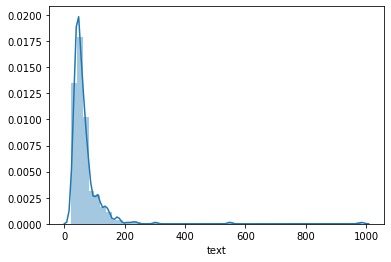

In [21]:
sns.distplot(Train_data_length)

In [22]:
okt = Okt()

In [23]:
# 불용어 또는 특수문자 제거 
clean_word = [] 
for i in X_train['text']:
    review_text = re.sub("[12?~3.,()''->\n]", " ", i)
    word_text = okt.morphs(review_text, stem=True)

    if True: word_text = [token for token in word_text if not token in set(['를','을','에','도',
                                                                            '수','이','가'])]
        
    clean_word.append(word_text)

In [24]:
clean_word

[['캡티브',
  '클라이언트',
  '인',
  '현대차',
  '양',
  '날',
  '의',
  '검',
  '으로',
  '작용',
  '하다',
  '수도',
  '있다',
  '듯',
  '현재',
  '경',
  '기',
  '침체',
  '와',
  '맞다',
  '물리다',
  '광고주',
  '재정',
  '상태',
  '와',
  '직결',
  '되어다',
  '있다',
  '광고인',
  '만큼',
  '향후',
  '년',
  '간',
  '매출',
  '성장',
  '율',
  '지지',
  '부진',
  '하다',
  '것',
  '으로',
  '예상',
  '신입사원',
  '매년',
  '마다',
  '뽑다',
  '않다',
  '것',
  '또한',
  '구직',
  '자',
  '들',
  '에게는',
  '아쉽다',
  '듯'],
 ['업무', '양', '부서', '바이', '부서', '라', '형평성', '맞다', '않다', '달다', '느낌', '많이', '받다'],
 ['직원', '전용', '의', '카페테리아', '헬스장', '사우나', '다양하다', '복지'],
 ['광고',
  '회사',
  '답지',
  '않다',
  '수직',
  '적',
  '기업',
  '문화',
  '모',
  '기업',
  '워낙',
  '수직',
  '적임',
  '광고주',
  '또한',
  '계열',
  '사이',
  '나',
  '업무',
  '적',
  '으로',
  '하',
  '대',
  '당',
  '함'],
 ['팀',
  '마다',
  '개인',
  '의',
  '역량',
  '드러내다',
  '있다',
  '기회',
  '천차만별',
  '여느',
  '대',
  '행사',
  '와',
  '같이',
  '업무',
  '과',
  '다',
  '로',
  '인하다',
  '스트레스'],
 ['복지',
  '좋다',
  '바쁘다',
  '때',
  '는',
  '바쁘다',
  '일어',
  '없다',
  '때',
 

1. 안녕하세요 저는 분석가 분식이 입니다.
2. '안녕하세요' '저' '분석가' '분식이' '입니다.'
3. ['안녕하세요' '저' '분석가' '분식이']
4. [11, 36, 33, 40 ,0,0,0,0,0,0,0,0,0,0,0]

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_word)

train_seq = tokenizer.texts_to_sequences(clean_word)

tokenizer.word_index

{'하다': 1,
 '있다': 2,
 '의': 3,
 '적': 4,
 '회사': 5,
 '광고': 6,
 '들': 7,
 '좋다': 8,
 '많다': 9,
 '복지': 10,
 '인': 11,
 '은': 12,
 '되다': 13,
 '팀': 14,
 '없다': 15,
 '으로': 16,
 '야근': 17,
 '일': 18,
 '않다': 19,
 '는': 20,
 '분위기': 21,
 '업무': 22,
 '과': 23,
 '업계': 24,
 '사람': 25,
 '에서': 26,
 '문화': 27,
 '한': 28,
 '것': 29,
 '로': 30,
 '보다': 31,
 '기업': 32,
 '와': 33,
 '직원': 34,
 '연봉': 35,
 '함': 36,
 '자동차': 37,
 '대기업': 38,
 '자다': 39,
 '자유롭다': 40,
 '내': 41,
 '편': 42,
 '현대': 43,
 '되어다': 44,
 '부서': 45,
 '이다': 46,
 '및': 47,
 '사내': 48,
 '광고주': 49,
 '너무': 50,
 '시스템': 51,
 '현': 52,
 '고': 53,
 '대': 54,
 '다': 55,
 '하고': 56,
 '라': 57,
 '현대차': 58,
 '아니다': 59,
 '지원': 60,
 '높다': 61,
 '크다': 62,
 '그룹': 63,
 '임': 64,
 '위': 65,
 '경험': 66,
 '안정': 67,
 '하지만': 68,
 '비': 69,
 '곳': 70,
 '사': 71,
 '정도': 72,
 '등': 73,
 '연차': 74,
 '다양하다': 75,
 '계열': 76,
 '일이': 77,
 '같다': 78,
 '가다': 79,
 '해외': 80,
 '매우': 81,
 '받다': 82,
 '때문': 83,
 '그렇다': 84,
 '생각': 85,
 '식당': 86,
 '많이': 87,
 '개인': 88,
 '심하다': 89,
 '대한': 90,
 '체계': 91,
 '환경': 92,
 '그': 93,


In [26]:
# 불용어 또는 특수문자 제거 
clean_word = [] 
for i in X_test['text']:
    review_text = re.sub("[12?~3.,()''->\n]", " ", i)
    word_text = okt.morphs(review_text, stem=True)

    if True: word_text = [token for token in word_text if not token in set(['를','을','에','도'])]
        
    clean_word.append(word_text)

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_word)

test_seq = tokenizer.texts_to_sequences(clean_word)

In [28]:
# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 80

# 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환합니다.
x_train_vec = pad_sequences(train_seq, maxlen=80, padding='post')
x_test_vec = pad_sequences(test_seq, maxlen=80, padding='post')

In [29]:
x_train_vec

array([[945, 108,  11, ...,   0,   0,   0],
       [ 22, 505,  45, ...,   0,   0,   0],
       [ 34, 956,   3, ...,   0,   0,   0],
       ...,
       [ 77,   9, 770, ...,   0,   0,   0],
       [ 43, 206,  80, ...,   0,   0,   0],
       [  6,   5, 659, ...,   0,   0,   0]])

In [30]:
x_train_vec = preprocessing.sequence.pad_sequences(x_train_vec, maxlen=maxlen)
x_test_vec = preprocessing.sequence.pad_sequences(x_test_vec, maxlen=maxlen)

In [31]:
x_train_vec

array([[945, 108,  11, ...,   0,   0,   0],
       [ 22, 505,  45, ...,   0,   0,   0],
       [ 34, 956,   3, ...,   0,   0,   0],
       ...,
       [ 77,   9, 770, ...,   0,   0,   0],
       [ 43, 206,  80, ...,   0,   0,   0],
       [  6,   5, 659, ...,   0,   0,   0]])

In [32]:
model = Sequential()
# 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding 층에 input_length를 지정합니다.
model.add(Embedding(10000, 8, input_length=maxlen))
# Embedding 층의 출력 크기는 (samples, maxlen, 8)가 됩니다.

# 3D 임베딩 텐서를 (samples, maxlen * 8) 크기의 2D 텐서로 펼칩니다.
model.add(Flatten())

# 분류기를 추가합니다.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train_vec, Y_train,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 641       
Total params: 80,641
Trainable params: 80,641
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 331 samples, validate on 83 samples
Epoch 1/120
331/331 [==============================] - 0s 520us/step - loss: 0.6925 - acc: 0.5287 - val_loss: 0.6973 - val_acc: 0.4337
Epoch 2/120
331/331 [==============================] - 0s 39us/step - loss: 0.6820 - acc: 0.5861 - val_loss: 0.6993 - val_acc: 0.4337
Epoch 3/120
331/331 [==============================] - 0s 39us/step - loss: 0.6731 - acc: 0.5891 - val_loss: 0.6984 - val_acc: 0.4217
Epoch 4/120
331/331 [==============================] - 0s 41us/step - loss: 0.6643 - acc: 0.6284 - val_loss: 0.7029 - val_acc: 0.4337
Epoch 5/120
331/331 [==============================] - 0s 39us/step - loss: 0.6547 - acc: 0.6254 - val_loss: 0.7008 - val_acc: 0.4337
Epoch 6/120
331/331 [==============================] - 0s 39us/step - loss: 0.6431 - acc: 0.6254 - val_loss: 0.6957 - val_acc: 0.4458
Epoch 7/120
331/331 [==============================] - 0s 39us/step - loss: 0.6309 - acc: 0.7221 - val_loss: 0.6962 - val_acc: 0.4458
Epoch 8/120
331/

331/331 [==============================] - 0s 39us/step - loss: 3.4196e-06 - acc: 1.0000 - val_loss: 0.5317 - val_acc: 0.8554


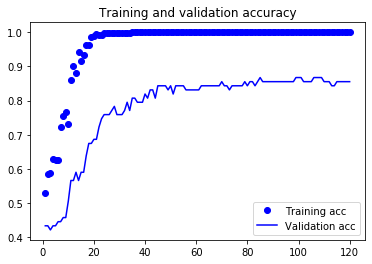

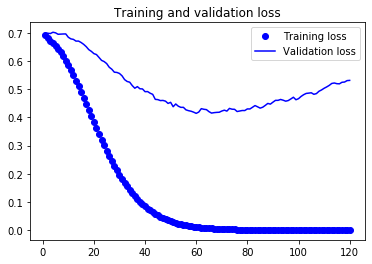

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train_vec, Y_train,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 8)             80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 85,281
Trainable params: 85,281
Non-trainable params: 0
_________________________________________________________________
Train on 331 samples, validate on 83 samples
Epoch 1/120
331/331 [==============================] - 1s 2ms/step - loss: 0.6934 - acc: 0.4955 - val_loss: 0.6975 - val_acc: 0.4337
Epoch 2/120
331/331 [==============================] - 0s 666us/step - loss: 0.6919 - acc: 0.5347 - val_loss: 0.7005 - val_acc: 0.4337
Epoch 3/120
331/331 [==============================] - 0s 690us/ste

Epoch 114/120
331/331 [==============================] - 0s 710us/step - loss: 1.5636e-06 - acc: 1.0000 - val_loss: 2.7672 - val_acc: 0.7952
Epoch 115/120
331/331 [==============================] - 0s 721us/step - loss: 1.2550e-06 - acc: 1.0000 - val_loss: 2.8134 - val_acc: 0.7952
Epoch 116/120
331/331 [==============================] - 0s 723us/step - loss: 1.0105e-06 - acc: 1.0000 - val_loss: 2.8579 - val_acc: 0.7952
Epoch 117/120
331/331 [==============================] - 0s 713us/step - loss: 8.1708e-07 - acc: 1.0000 - val_loss: 2.9009 - val_acc: 0.7952
Epoch 118/120
331/331 [==============================] - 0s 724us/step - loss: 6.6388e-07 - acc: 1.0000 - val_loss: 2.9437 - val_acc: 0.7952
Epoch 119/120
331/331 [==============================] - 0s 725us/step - loss: 5.4269e-07 - acc: 1.0000 - val_loss: 2.9840 - val_acc: 0.7952
Epoch 120/120
331/331 [==============================] - 0s 717us/step - loss: 4.4594e-07 - acc: 1.0000 - val_loss: 3.0238 - val_acc: 0.7952


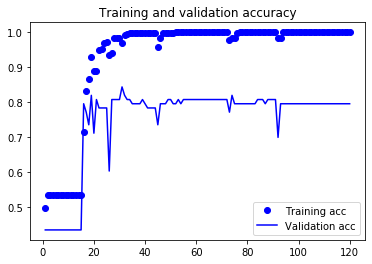

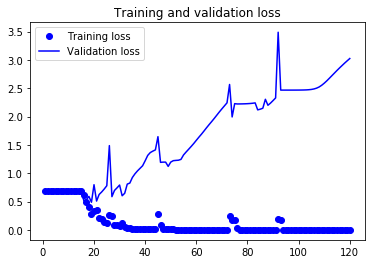

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Conv1

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train_vec, Y_train,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 8)             80000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 32)            1824      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 32)             7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 89,057
Trainable params: 89,057
Non-trainable params: 0
__________________________________________________

Epoch 53/120
331/331 [==============================] - 0s 87us/step - loss: 0.5474 - acc: 0.8671 - val_loss: 0.6535 - val_acc: 0.5422
Epoch 54/120
331/331 [==============================] - 0s 87us/step - loss: 0.5417 - acc: 0.8761 - val_loss: 0.6557 - val_acc: 0.4940
Epoch 55/120
331/331 [==============================] - 0s 87us/step - loss: 0.5363 - acc: 0.8248 - val_loss: 0.6535 - val_acc: 0.4940
Epoch 56/120
331/331 [==============================] - 0s 87us/step - loss: 0.5300 - acc: 0.8610 - val_loss: 0.6501 - val_acc: 0.5301
Epoch 57/120
331/331 [==============================] - 0s 87us/step - loss: 0.5239 - acc: 0.8822 - val_loss: 0.6506 - val_acc: 0.5060
Epoch 58/120
331/331 [==============================] - 0s 89us/step - loss: 0.5177 - acc: 0.8550 - val_loss: 0.6469 - val_acc: 0.5422
Epoch 59/120
331/331 [==============================] - 0s 87us/step - loss: 0.5113 - acc: 0.8610 - val_loss: 0.6389 - val_acc: 0.5663
Epoch 60/120
331/331 [==============================] -

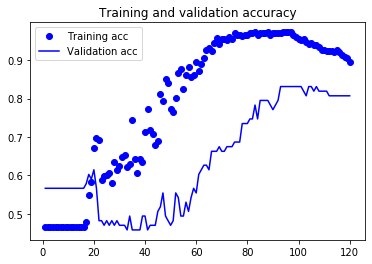

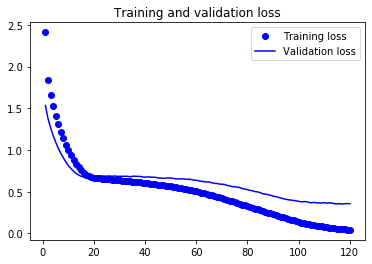

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 텍스트 유사도 (Text Similarity)


* 서로 비슷한 텍스트가 얼마나 유사한지 표현하는 방식, 문장의 구조는 다르나 의미가 같은경우 / 동의어를 사용해 문장을 구성한 경우 
* 사용하고 있는 문장의 유사도를 측정
* 데이터를 구성하는게 어렵고, 정량화 하는데 한계가 존재함 
* 같은 단어의 갯수를 사용해 유사도를 측정하는 방법 / 형태소로 나누어 비교하는 방법 / 자소 단위로 나누어 단어를 비교하는 방법 ..
* 보편적인 방법은, 단어,형태소, 유사도의 상관없이 텍스트를 벡터로 변환한 다음 벡터화 된 문장을 비교하는 형식을 이용 


    - 자카드 유사도 (Jaccard Similarity) : 두 문장을 각각 단어의 집합으로 만든 뒤 두 집합을 통해 유사도를 측정하는 방식
        * 유사도를 측정하는 방법은 두 집합의 교집합인 공통된 단어의 개수를 두 집합의 합집합으로(전체 단어수) 나눈는 방식
        * 결과 값이 공통 원소의 갯수에 따라 0 ~ 1 사이로 도출  


    - 유클리디언 유사도 (Euclidean Similarity) : 벡터간의 거리를 유클리드 거리를 이용해 계산하여, 단어간의 거리가 얼마나 떨어져 있는가 계산 
        * 유클리드 거리는 결과값에 대한 범위가 정해져 있지 않아 보통, 정규화 또는 Scaling을 통해 재 계산한 뒤 평가 
        * L2 Distance
        
        
    - 맨하탄 유사도 (Manhattan Simailarity)
        * 격자 구조로 된 좌표계에서 최소로 움직일 수 있는 경로를 (최단경로) 계산 
        * L1 Distance 
    
    
    - 코사인 유사도 : 두 개의 단어 벡터값에서 코사인 각도를 구하여, 유사도를 계산하는 방식 
        * -1 에서 1 사의 값을 가지며, 1로 갈 수록 유사하다고 함 
        * 유사도를 계산할때 가장 많이 활용되는 방식 
        * 다른 접근방식에 비해 성능이 더 좋게 나온다 (벡터의 수학적인 방향성이 단어의 정보를 더욱 잘 표현한다/ 유사할 수록 같은방향, 다를 수록 직교 Othogonal)

In [ ]:
!pip install networkx 

In [38]:
import pandas as pd 
import networkx as nx
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
sent = ("파이썬 을 이용 해 데이터 분석 을 하면, 여러 산업 에서 인사이트 를 쉽게 얻을 수 있다.", 
        "산업 에서 인사이트 를 얻기 위해선 주로 파이썬 이라는 도구 를 활용 해 데이터 분석 을 실시 한다.")

In [40]:
# Tfidvectorizer 객체 선언 
tifidf_Vectorizer = TfidfVectorizer()

# 문장 벡터화 진행 
tifidf_Matrix = tifidf_Vectorizer.fit_transform(sent)
idf = tifidf_Vectorizer.idf_
pd.DataFrame({'단어': tifidf_Vectorizer.get_feature_names(), "유사도":idf}).sort_values(by='유사도',ascending=False)

,단어,유사도
10,위해선,1.405465
9,여러,1.405465
18,한다,1.405465
17,하면,1.405465
15,주로,1.405465
14,있다,1.405465
12,이용,1.405465
11,이라는,1.405465
1,도구,1.405465
19,활용,1.405465


In [42]:
# 문장 벡터화 진행 
tifidf_Matrix = tifidf_Vectorizer.fit_transform(df1['단점'])
idf = tifidf_Vectorizer.idf_
pd.DataFrame({'단어': tifidf_Vectorizer.get_feature_names(), "유사도":idf}).sort_values(by='유사도',ascending=False).head(10)

,단어,유사도
0,0830에,5.749271
1549,왜이리,5.749271
1563,운영해서,5.749271
1562,우직한,5.749271
1561,우수수,5.749271
1560,우선주의에,5.749271
1559,우린,5.749271
1558,욕구를,5.749271
1557,요소를,5.749271
1556,요구와,5.749271


In [43]:
hannanum = Hannanum()

In [46]:
dataset = [] 
for i in (df1['단점']):
    dataset.append(hannanum.nouns(re.sub("[12?~3.,()''->\n]", " ", i)))

In [47]:
from apyori import apriori

In [48]:
result = (list(apriori(dataset,min_support = 0.015)))
df2 = pd.DataFrame(result)

In [49]:
df2.shape

(185, 3)

In [50]:
df2['length'] = df2['items'].apply(lambda x : len(x))
df3 = df2.loc[df2['length']==2]
df3.head()

,items,support,ordered_statistics,length
123,"(강도, 업무)",0.017391,"[((), (강도, 업무), 0.017391304347826087, 1.0), ((...",2
124,"(광고, 것)",0.017391,"[((), (광고, 것), 0.017391304347826087, 1.0), ((것...",2
125,"(보수적, 것)",0.017391,"[((), (보수적, 것), 0.017391304347826087, 1.0), ((...",2
126,"(복지, 것)",0.017391,"[((), (것, 복지), 0.017391304347826087, 1.0), ((것...",2
127,"(수, 것)",0.026087,"[((), (수, 것), 0.02608695652173913, 1.0), ((것),...",2


In [51]:
G = nx.Graph()
pr = nx.pagerank(G)
G.add_edges_from(df3['items'])

In [52]:
pos = nx.kamada_kawai_layout(G)
# 원형 Layer 
#pos = nx.shell_layout(G)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


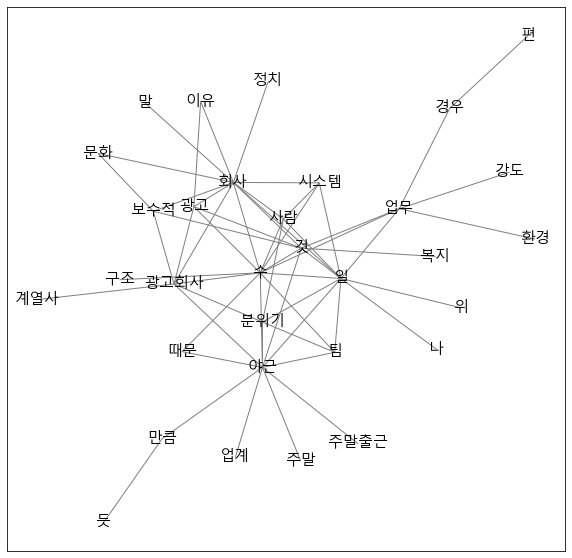

In [53]:
plt.figure(figsize=[10,10])
nx.draw_networkx(G, font_family='Malgun Gothic',font_size=15,
                 pos=pos, alpgha=0.5,edge_color='0.5',node_color = list(pr.values()))